# Inception Model

El modelo Inception v3 tarda semanas en entrenarse en un computador con 8 GPUs Tesla K40, el cual probablemente cuesta $ 30,000 por lo que es imposible entrenarlo en una PC normal. En su lugar, descargamos el modelo de Inception pre-entrenado y lo usamos para clasificar las imágenes.

El modelo Inception v3 tiene casi 25 millones de parámetros y utiliza 5 mil millones de operaciones multiplicativas para clasificar una sola imagen. En un PC moderno sin una GPU esto puede hacerse en una fracción de segundo por imagen.


## Flowchart

El gráfico siguiente muestra cómo fluyen los datos en el modelo Inception v3, que es una red neuronal convolucional con muchas capas y una estructura complicada. El [artículo](http://arxiv.org/pdf/1512.00567v3.pdf) da más detalles sobre cómo se construye el modelo Inception y por qué está diseñado de esa manera. Pero los autores admiten que no entienden completamente por qué funciona.

El modelo Inception tiene dos salidas softmax. Uno se utiliza durante el entrenamiento de la red neuronal y el otro se utiliza para clasificar las imágenes después del entrenamiento ha terminado, también conocido como inferencia.

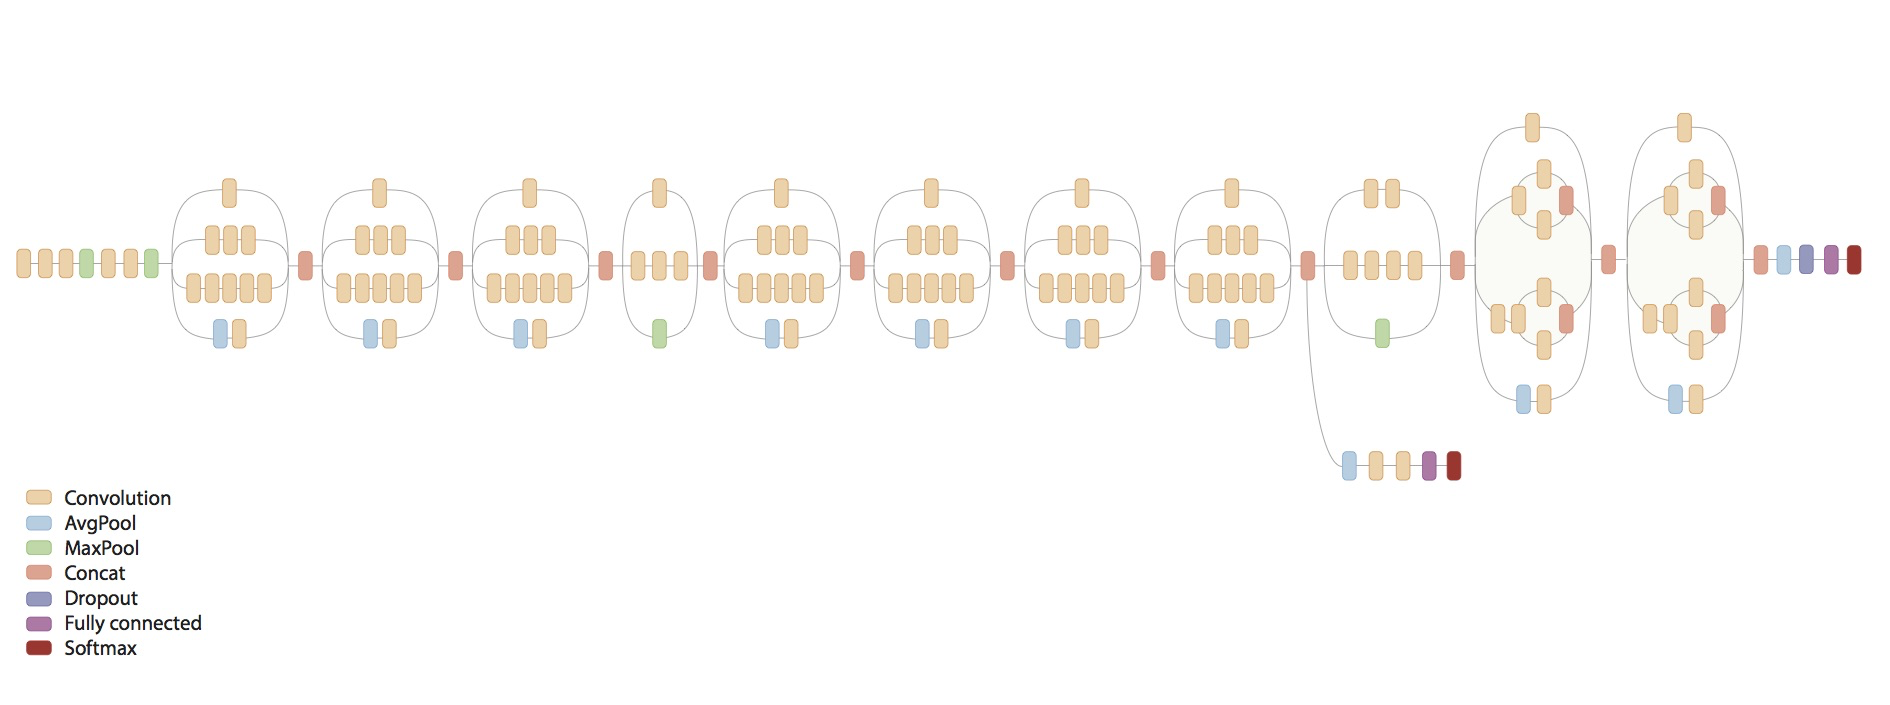

In [4]:
from IPython.display import Image, display
Image('images/07_inception_flowchart.png')

## Implementación del Modelo Usando TensorFlow-Slim

TF-Slim es una biblioteca ligera para definir, entrenar y evaluar modelos en TensorFlow. Permite definir redes complejas de forma rápida y concisa, manteniendo transparente la arquitectura de un modelo y explicando sus hiperparámetros.

* Permite la definición de modelos mucho más compactos eliminando el código repetitivo. Esto se logra mediante el manejo de argumentos y numerosas de alto nivel. Estas herramientas aumentan legibilidad y facilidad de mantenimiento, reducen la probabilidad de copiar y pegar valores de hiperparámetro y simplifica la optimización del hiperparámetro.
* Facilita el desarrollo de modelos facilitando las funciones de pérdida.
* Utiliza una implementación concisa de [Inception v3](http://arxiv.org/abs/1512.00567).


In [56]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

from slim import ops
from slim import scopes


def inception_v3(inputs,
                 dropout_keep_prob=0.8,
                 num_classes=1000,
                 is_training=True,
                 restore_logits=True,
                 scope=''):
  """Latest Inception from http://arxiv.org/abs/1512.00567.

    "Rethinking the Inception Architecture for Computer Vision"

    Christian Szegedy, Vincent Vanhoucke, Sergey Ioffe, Jonathon Shlens,
    Zbigniew Wojna

  Args:
    inputs: a tensor of size [batch_size, height, width, channels].
    dropout_keep_prob: dropout keep_prob.
    num_classes: number of predicted classes.
    is_training: whether is training or not.
    restore_logits: whether or not the logits layers should be restored.
      Useful for fine-tuning a model with different num_classes.
    scope: Optional scope for name_scope.

  Returns:
    a list containing 'logits', 'aux_logits' Tensors.
  """
  # end_points will collect relevant activations for external use, for example
  # summaries or losses.
  end_points = {}
  with tf.name_scope(scope, 'inception_v3', [inputs]):
    with scopes.arg_scope([ops.conv2d, ops.fc, ops.batch_norm, ops.dropout],
                          is_training=is_training):
      with scopes.arg_scope([ops.conv2d, ops.max_pool, ops.avg_pool],
                            stride=1, padding='VALID'):
        # 299 x 299 x 3
        end_points['conv0'] = ops.conv2d(inputs, 32, [3, 3], stride=2,
                                         scope='conv0')
        # 149 x 149 x 32
        end_points['conv1'] = ops.conv2d(end_points['conv0'], 32, [3, 3],
                                         scope='conv1')
        # 147 x 147 x 32
        end_points['conv2'] = ops.conv2d(end_points['conv1'], 64, [3, 3],
                                         padding='SAME', scope='conv2')
        # 147 x 147 x 64
        end_points['pool1'] = ops.max_pool(end_points['conv2'], [3, 3],
                                           stride=2, scope='pool1')
        # 73 x 73 x 64
        end_points['conv3'] = ops.conv2d(end_points['pool1'], 80, [1, 1],
                                         scope='conv3')
        # 73 x 73 x 80.
        end_points['conv4'] = ops.conv2d(end_points['conv3'], 192, [3, 3],
                                         scope='conv4')
        # 71 x 71 x 192.
        end_points['pool2'] = ops.max_pool(end_points['conv4'], [3, 3],
                                           stride=2, scope='pool2')
        # 35 x 35 x 192.
        net = end_points['pool2']
      # Inception blocks
      with scopes.arg_scope([ops.conv2d, ops.max_pool, ops.avg_pool],
                            stride=1, padding='SAME'):
        # mixed: 35 x 35 x 256.
        with tf.variable_scope('mixed_35x35x256a'):
          with tf.variable_scope('branch1x1'):
            branch1x1 = ops.conv2d(net, 64, [1, 1])
          with tf.variable_scope('branch5x5'):
            branch5x5 = ops.conv2d(net, 48, [1, 1])
            branch5x5 = ops.conv2d(branch5x5, 64, [5, 5])
          with tf.variable_scope('branch3x3dbl'):
            branch3x3dbl = ops.conv2d(net, 64, [1, 1])
            branch3x3dbl = ops.conv2d(branch3x3dbl, 96, [3, 3])
            branch3x3dbl = ops.conv2d(branch3x3dbl, 96, [3, 3])
          with tf.variable_scope('branch_pool'):
            branch_pool = ops.avg_pool(net, [3, 3])
            branch_pool = ops.conv2d(branch_pool, 32, [1, 1])
          net = tf.concat(axis=3, values=[branch1x1, branch5x5, branch3x3dbl, branch_pool])
          end_points['mixed_35x35x256a'] = net
        # mixed_1: 35 x 35 x 288.
        with tf.variable_scope('mixed_35x35x288a'):
          with tf.variable_scope('branch1x1'):
            branch1x1 = ops.conv2d(net, 64, [1, 1])
          with tf.variable_scope('branch5x5'):
            branch5x5 = ops.conv2d(net, 48, [1, 1])
            branch5x5 = ops.conv2d(branch5x5, 64, [5, 5])
          with tf.variable_scope('branch3x3dbl'):
            branch3x3dbl = ops.conv2d(net, 64, [1, 1])
            branch3x3dbl = ops.conv2d(branch3x3dbl, 96, [3, 3])
            branch3x3dbl = ops.conv2d(branch3x3dbl, 96, [3, 3])
          with tf.variable_scope('branch_pool'):
            branch_pool = ops.avg_pool(net, [3, 3])
            branch_pool = ops.conv2d(branch_pool, 64, [1, 1])
          net = tf.concat(axis=3, values=[branch1x1, branch5x5, branch3x3dbl, branch_pool])
          end_points['mixed_35x35x288a'] = net
        # mixed_2: 35 x 35 x 288.
        with tf.variable_scope('mixed_35x35x288b'):
          with tf.variable_scope('branch1x1'):
            branch1x1 = ops.conv2d(net, 64, [1, 1])
          with tf.variable_scope('branch5x5'):
            branch5x5 = ops.conv2d(net, 48, [1, 1])
            branch5x5 = ops.conv2d(branch5x5, 64, [5, 5])
          with tf.variable_scope('branch3x3dbl'):
            branch3x3dbl = ops.conv2d(net, 64, [1, 1])
            branch3x3dbl = ops.conv2d(branch3x3dbl, 96, [3, 3])
            branch3x3dbl = ops.conv2d(branch3x3dbl, 96, [3, 3])
          with tf.variable_scope('branch_pool'):
            branch_pool = ops.avg_pool(net, [3, 3])
            branch_pool = ops.conv2d(branch_pool, 64, [1, 1])
          net = tf.concat(axis=3, values=[branch1x1, branch5x5, branch3x3dbl, branch_pool])
          end_points['mixed_35x35x288b'] = net
        # mixed_3: 17 x 17 x 768.
        with tf.variable_scope('mixed_17x17x768a'):
          with tf.variable_scope('branch3x3'):
            branch3x3 = ops.conv2d(net, 384, [3, 3], stride=2, padding='VALID')
          with tf.variable_scope('branch3x3dbl'):
            branch3x3dbl = ops.conv2d(net, 64, [1, 1])
            branch3x3dbl = ops.conv2d(branch3x3dbl, 96, [3, 3])
            branch3x3dbl = ops.conv2d(branch3x3dbl, 96, [3, 3],
                                      stride=2, padding='VALID')
          with tf.variable_scope('branch_pool'):
            branch_pool = ops.max_pool(net, [3, 3], stride=2, padding='VALID')
          net = tf.concat(axis=3, values=[branch3x3, branch3x3dbl, branch_pool])
          end_points['mixed_17x17x768a'] = net
        # mixed4: 17 x 17 x 768.
        with tf.variable_scope('mixed_17x17x768b'):
          with tf.variable_scope('branch1x1'):
            branch1x1 = ops.conv2d(net, 192, [1, 1])
          with tf.variable_scope('branch7x7'):
            branch7x7 = ops.conv2d(net, 128, [1, 1])
            branch7x7 = ops.conv2d(branch7x7, 128, [1, 7])
            branch7x7 = ops.conv2d(branch7x7, 192, [7, 1])
          with tf.variable_scope('branch7x7dbl'):
            branch7x7dbl = ops.conv2d(net, 128, [1, 1])
            branch7x7dbl = ops.conv2d(branch7x7dbl, 128, [7, 1])
            branch7x7dbl = ops.conv2d(branch7x7dbl, 128, [1, 7])
            branch7x7dbl = ops.conv2d(branch7x7dbl, 128, [7, 1])
            branch7x7dbl = ops.conv2d(branch7x7dbl, 192, [1, 7])
          with tf.variable_scope('branch_pool'):
            branch_pool = ops.avg_pool(net, [3, 3])
            branch_pool = ops.conv2d(branch_pool, 192, [1, 1])
          net = tf.concat(axis=3, values=[branch1x1, branch7x7, branch7x7dbl, branch_pool])
          end_points['mixed_17x17x768b'] = net
        # mixed_5: 17 x 17 x 768.
        with tf.variable_scope('mixed_17x17x768c'):
          with tf.variable_scope('branch1x1'):
            branch1x1 = ops.conv2d(net, 192, [1, 1])
          with tf.variable_scope('branch7x7'):
            branch7x7 = ops.conv2d(net, 160, [1, 1])
            branch7x7 = ops.conv2d(branch7x7, 160, [1, 7])
            branch7x7 = ops.conv2d(branch7x7, 192, [7, 1])
          with tf.variable_scope('branch7x7dbl'):
            branch7x7dbl = ops.conv2d(net, 160, [1, 1])
            branch7x7dbl = ops.conv2d(branch7x7dbl, 160, [7, 1])
            branch7x7dbl = ops.conv2d(branch7x7dbl, 160, [1, 7])
            branch7x7dbl = ops.conv2d(branch7x7dbl, 160, [7, 1])
            branch7x7dbl = ops.conv2d(branch7x7dbl, 192, [1, 7])
          with tf.variable_scope('branch_pool'):
            branch_pool = ops.avg_pool(net, [3, 3])
            branch_pool = ops.conv2d(branch_pool, 192, [1, 1])
          net = tf.concat(axis=3, values=[branch1x1, branch7x7, branch7x7dbl, branch_pool])
          end_points['mixed_17x17x768c'] = net
        # mixed_6: 17 x 17 x 768.
        with tf.variable_scope('mixed_17x17x768d'):
          with tf.variable_scope('branch1x1'):
            branch1x1 = ops.conv2d(net, 192, [1, 1])
          with tf.variable_scope('branch7x7'):
            branch7x7 = ops.conv2d(net, 160, [1, 1])
            branch7x7 = ops.conv2d(branch7x7, 160, [1, 7])
            branch7x7 = ops.conv2d(branch7x7, 192, [7, 1])
          with tf.variable_scope('branch7x7dbl'):
            branch7x7dbl = ops.conv2d(net, 160, [1, 1])
            branch7x7dbl = ops.conv2d(branch7x7dbl, 160, [7, 1])
            branch7x7dbl = ops.conv2d(branch7x7dbl, 160, [1, 7])
            branch7x7dbl = ops.conv2d(branch7x7dbl, 160, [7, 1])
            branch7x7dbl = ops.conv2d(branch7x7dbl, 192, [1, 7])
          with tf.variable_scope('branch_pool'):
            branch_pool = ops.avg_pool(net, [3, 3])
            branch_pool = ops.conv2d(branch_pool, 192, [1, 1])
          net = tf.concat(axis=3, values=[branch1x1, branch7x7, branch7x7dbl, branch_pool])
          end_points['mixed_17x17x768d'] = net
        # mixed_7: 17 x 17 x 768.
        with tf.variable_scope('mixed_17x17x768e'):
          with tf.variable_scope('branch1x1'):
            branch1x1 = ops.conv2d(net, 192, [1, 1])
          with tf.variable_scope('branch7x7'):
            branch7x7 = ops.conv2d(net, 192, [1, 1])
            branch7x7 = ops.conv2d(branch7x7, 192, [1, 7])
            branch7x7 = ops.conv2d(branch7x7, 192, [7, 1])
          with tf.variable_scope('branch7x7dbl'):
            branch7x7dbl = ops.conv2d(net, 192, [1, 1])
            branch7x7dbl = ops.conv2d(branch7x7dbl, 192, [7, 1])
            branch7x7dbl = ops.conv2d(branch7x7dbl, 192, [1, 7])
            branch7x7dbl = ops.conv2d(branch7x7dbl, 192, [7, 1])
            branch7x7dbl = ops.conv2d(branch7x7dbl, 192, [1, 7])
          with tf.variable_scope('branch_pool'):
            branch_pool = ops.avg_pool(net, [3, 3])
            branch_pool = ops.conv2d(branch_pool, 192, [1, 1])
          net = tf.concat(axis=3, values=[branch1x1, branch7x7, branch7x7dbl, branch_pool])
          end_points['mixed_17x17x768e'] = net
        # Auxiliary Head logits
        aux_logits = tf.identity(end_points['mixed_17x17x768e'])
        with tf.variable_scope('aux_logits'):
          aux_logits = ops.avg_pool(aux_logits, [5, 5], stride=3,
                                    padding='VALID')
          aux_logits = ops.conv2d(aux_logits, 128, [1, 1], scope='proj')
          # Shape of feature map before the final layer.
          shape = aux_logits.get_shape()
          aux_logits = ops.conv2d(aux_logits, 768, shape[1:3], stddev=0.01,
                                  padding='VALID')
          aux_logits = ops.flatten(aux_logits)
          aux_logits = ops.fc(aux_logits, num_classes, activation=None,
                              stddev=0.001, restore=restore_logits)
          end_points['aux_logits'] = aux_logits
        # mixed_8: 8 x 8 x 1280.
        # Note that the scope below is not changed to not void previous
        # checkpoints.
        # (TODO) Fix the scope when appropriate.
        with tf.variable_scope('mixed_17x17x1280a'):
          with tf.variable_scope('branch3x3'):
            branch3x3 = ops.conv2d(net, 192, [1, 1])
            branch3x3 = ops.conv2d(branch3x3, 320, [3, 3], stride=2,
                                   padding='VALID')
          with tf.variable_scope('branch7x7x3'):
            branch7x7x3 = ops.conv2d(net, 192, [1, 1])
            branch7x7x3 = ops.conv2d(branch7x7x3, 192, [1, 7])
            branch7x7x3 = ops.conv2d(branch7x7x3, 192, [7, 1])
            branch7x7x3 = ops.conv2d(branch7x7x3, 192, [3, 3],
                                     stride=2, padding='VALID')
          with tf.variable_scope('branch_pool'):
            branch_pool = ops.max_pool(net, [3, 3], stride=2, padding='VALID')
          net = tf.concat(axis=3, values=[branch3x3, branch7x7x3, branch_pool])
          end_points['mixed_17x17x1280a'] = net
        # mixed_9: 8 x 8 x 2048.
        with tf.variable_scope('mixed_8x8x2048a'):
          with tf.variable_scope('branch1x1'):
            branch1x1 = ops.conv2d(net, 320, [1, 1])
          with tf.variable_scope('branch3x3'):
            branch3x3 = ops.conv2d(net, 384, [1, 1])
            branch3x3 = tf.concat(axis=3, values=[ops.conv2d(branch3x3, 384, [1, 3]),
                                                  ops.conv2d(branch3x3, 384, [3, 1])])
          with tf.variable_scope('branch3x3dbl'):
            branch3x3dbl = ops.conv2d(net, 448, [1, 1])
            branch3x3dbl = ops.conv2d(branch3x3dbl, 384, [3, 3])
            branch3x3dbl = tf.concat(axis=3, values=[ops.conv2d(branch3x3dbl, 384, [1, 3]),
                                                     ops.conv2d(branch3x3dbl, 384, [3, 1])])
          with tf.variable_scope('branch_pool'):
            branch_pool = ops.avg_pool(net, [3, 3])
            branch_pool = ops.conv2d(branch_pool, 192, [1, 1])
          net = tf.concat(axis=3, values=[branch1x1, branch3x3, branch3x3dbl, branch_pool])
          end_points['mixed_8x8x2048a'] = net
        # mixed_10: 8 x 8 x 2048.
        with tf.variable_scope('mixed_8x8x2048b'):
          with tf.variable_scope('branch1x1'):
            branch1x1 = ops.conv2d(net, 320, [1, 1])
          with tf.variable_scope('branch3x3'):
            branch3x3 = ops.conv2d(net, 384, [1, 1])
            branch3x3 = tf.concat(axis=3, values=[ops.conv2d(branch3x3, 384, [1, 3]),
                                                  ops.conv2d(branch3x3, 384, [3, 1])])
          with tf.variable_scope('branch3x3dbl'):
            branch3x3dbl = ops.conv2d(net, 448, [1, 1])
            branch3x3dbl = ops.conv2d(branch3x3dbl, 384, [3, 3])
            branch3x3dbl = tf.concat(axis=3, values=[ops.conv2d(branch3x3dbl, 384, [1, 3]),
                                                     ops.conv2d(branch3x3dbl, 384, [3, 1])])
          with tf.variable_scope('branch_pool'):
            branch_pool = ops.avg_pool(net, [3, 3])
            branch_pool = ops.conv2d(branch_pool, 192, [1, 1])
          net = tf.concat(axis=3, values=[branch1x1, branch3x3, branch3x3dbl, branch_pool])
          end_points['mixed_8x8x2048b'] = net
        # Final pooling and prediction
        with tf.variable_scope('logits'):
          shape = net.get_shape()
          net = ops.avg_pool(net, shape[1:3], padding='VALID', scope='pool')
          # 1 x 1 x 2048
          net = ops.dropout(net, dropout_keep_prob, scope='dropout')
          net = ops.flatten(net, scope='flatten')
          # 2048
          logits = ops.fc(net, num_classes, activation=None, scope='logits',
                          restore=restore_logits)
          # 1000
          end_points['logits'] = logits
          end_points['predictions'] = tf.nn.softmax(logits, name='predictions')
      return logits, end_points


def inception_v3_parameters(weight_decay=0.00004, stddev=0.1,
                            batch_norm_decay=0.9997, batch_norm_epsilon=0.001):
  """Yields the scope with the default parameters for inception_v3.

  Args:
    weight_decay: the weight decay for weights variables.
    stddev: standard deviation of the truncated guassian weight distribution.
    batch_norm_decay: decay for the moving average of batch_norm momentums.
    batch_norm_epsilon: small float added to variance to avoid dividing by zero.

  Yields:
    a arg_scope with the parameters needed for inception_v3.
  """
  # Set weight_decay for weights in Conv and FC layers.
  with scopes.arg_scope([ops.conv2d, ops.fc],
                        weight_decay=weight_decay):
    # Set stddev, activation and parameters for batch_norm.
    with scopes.arg_scope([ops.conv2d],
                          stddev=stddev,
                          activation=tf.nn.relu,
                          batch_norm_params={
                              'decay': batch_norm_decay,
                              'epsilon': batch_norm_epsilon}) as arg_scope:
      yield arg_scope

## Carga del modelo a partir de un archivo

Se optó por cargar un modelo con los pesos pre-entrenados debido al excesivo tiempo que tomaría entrenar el modelo.

## Importaciones

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

# Functions and classes for loading and using the Inception model.
#import inception

import numpy as np
import tensorflow as tf
import download
from cache import cache
import os
import sys


This was developed using Python 3.5.2 (Anaconda) and TensorFlow version:

In [6]:
tf.__version__

'0.12.1'

In [25]:
########################################################################
# Various directories and file-names.

# Internet URL for the tar-file with the Inception model.
# Note that this might change in the future and will need to be updated.
data_url = "http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz"

# Directory to store the downloaded data.
data_dir = "inception/"

# File containing the mappings between class-number and uid. (Downloaded)
path_uid_to_cls = "imagenet_2012_challenge_label_map_proto.pbtxt"

# File containing the mappings between uid and string. (Downloaded)
path_uid_to_name = "imagenet_synset_to_human_label_map.txt"

# File containing the TensorFlow graph definition. (Downloaded)
path_graph_def = "classify_image_graph_def.pb"

########################################################################

In [26]:
def maybe_download():
    """
    Download the Inception model from the internet if it does not already
    exist in the data_dir. The file is about 85 MB.
    """

    print("Downloading Inception v3 Model ...")
    download.maybe_download_and_extract(url=data_url, download_dir=data_dir)


########################################################################

In [27]:
class NameLookup:
    """
    Used for looking up the name associated with a class-number.
    This is used to print the name of a class instead of its number,
    e.g. "plant" or "horse".

    Maps between:
    - cls is the class-number as an integer between 1 and 1000 (inclusive).
    - uid is a class-id as a string from the ImageNet data-set, e.g. "n00017222".
    - name is the class-name as a string, e.g. "plant, flora, plant life"

    There are actually 1008 output classes of the Inception model
    but there are only 1000 named classes in these mapping-files.
    The remaining 8 output classes of the model should not be used.
    """

    def __init__(self):
        # Mappings between uid, cls and name are dicts, where insertions and
        # lookup have O(1) time-usage on average, but may be O(n) in worst case.
        self._uid_to_cls = {}   # Map from uid to cls.
        self._uid_to_name = {}  # Map from uid to name.
        self._cls_to_uid = {}   # Map from cls to uid.

        # Read the uid-to-name mappings from file.
        path = os.path.join(data_dir, path_uid_to_name)
        with open(file=path, mode='r') as file:
            # Read all lines from the file.
            lines = file.readlines()

            for line in lines:
                # Remove newlines.
                line = line.replace("\n", "")

                # Split the line on tabs.
                elements = line.split("\t")

                # Get the uid.
                uid = elements[0]

                # Get the class-name.
                name = elements[1]

                # Insert into the lookup-dict.
                self._uid_to_name[uid] = name

        # Read the uid-to-cls mappings from file.
        path = os.path.join(data_dir, path_uid_to_cls)
        with open(file=path, mode='r') as file:
            # Read all lines from the file.
            lines = file.readlines()

            for line in lines:
                # We assume the file is in the proper format,
                # so the following lines come in pairs. Other lines are ignored.

                if line.startswith("  target_class: "):
                    # This line must be the class-number as an integer.

                    # Split the line.
                    elements = line.split(": ")

                    # Get the class-number as an integer.
                    cls = int(elements[1])

                elif line.startswith("  target_class_string: "):
                    # This line must be the uid as a string.

                    # Split the line.
                    elements = line.split(": ")

                    # Get the uid as a string e.g. "n01494475"
                    uid = elements[1]

                    # Remove the enclosing "" from the string.
                    uid = uid[1:-2]

                    # Insert into the lookup-dicts for both ways between uid and cls.
                    self._uid_to_cls[uid] = cls
                    self._cls_to_uid[cls] = uid

    def uid_to_cls(self, uid):
        """
        Return the class-number as an integer for the given uid-string.
        """

        return self._uid_to_cls[uid]

    def uid_to_name(self, uid, only_first_name=False):
        """
        Return the class-name for the given uid string.

        Some class-names are lists of names, if you only want the first name,
        then set only_first_name=True.
        """

        # Lookup the name from the uid.
        name = self._uid_to_name[uid]

        # Only use the first name in the list?
        if only_first_name:
            name = name.split(",")[0]

        return name

    def cls_to_name(self, cls, only_first_name=False):
        """
        Return the class-name from the integer class-number.

        Some class-names are lists of names, if you only want the first name,
        then set only_first_name=True.
        """

        # Lookup the uid from the cls.
        uid = self._cls_to_uid[cls]

        # Lookup the name from the uid.
        name = self.uid_to_name(uid=uid, only_first_name=only_first_name)

        return name


########################################################################

In [28]:
class Inception:
    """
    The Inception model is a Deep Neural Network which has already been
    trained for classifying images into 1000 different categories.

    When you create a new instance of this class, the Inception model
    will be loaded and can be used immediately without training.

    The Inception model can also be used for Transfer Learning.
    """

    # Name of the tensor for feeding the input image as jpeg.
    tensor_name_input_jpeg = "DecodeJpeg/contents:0"

    # Name of the tensor for feeding the decoded input image.
    # Use this for feeding images in other formats than jpeg.
    tensor_name_input_image = "DecodeJpeg:0"

    # Name of the tensor for the resized input image.
    # This is used to retrieve the image after it has been resized.
    tensor_name_resized_image = "ResizeBilinear:0"

    # Name of the tensor for the output of the softmax-classifier.
    # This is used for classifying images with the Inception model.
    tensor_name_softmax = "softmax:0"

    # Name of the tensor for the unscaled outputs of the softmax-classifier (aka. logits).
    tensor_name_softmax_logits = "softmax/logits:0"

    # Name of the tensor for the output of the Inception model.
    # This is used for Transfer Learning.
    tensor_name_transfer_layer = "pool_3:0"

    def __init__(self):
        # Mappings between class-numbers and class-names.
        # Used to print the class-name as a string e.g. "horse" or "plant".
        self.name_lookup = NameLookup()

        # Now load the Inception model from file. The way TensorFlow
        # does this is confusing and requires several steps.

        # Create a new TensorFlow computational graph.
        self.graph = tf.Graph()

        # Set the new graph as the default.
        with self.graph.as_default():

            # TensorFlow graphs are saved to disk as so-called Protocol Buffers
            # aka. proto-bufs which is a file-format that works on multiple
            # platforms. In this case it is saved as a binary file.

            # Open the graph-def file for binary reading.
            path = os.path.join(data_dir, path_graph_def)
            with tf.gfile.FastGFile(path, 'rb') as file:
                # The graph-def is a saved copy of a TensorFlow graph.
                # First we need to create an empty graph-def.
                graph_def = tf.GraphDef()

                # Then we load the proto-buf file into the graph-def.
                graph_def.ParseFromString(file.read())

                # Finally we import the graph-def to the default TensorFlow graph.
                tf.import_graph_def(graph_def, name='')

                # Now self.graph holds the Inception model from the proto-buf file.

        # Get the output of the Inception model by looking up the tensor
        # with the appropriate name for the output of the softmax-classifier.
        self.y_pred = self.graph.get_tensor_by_name(self.tensor_name_softmax)

        # Get the unscaled outputs for the Inception model (aka. softmax-logits).
        self.y_logits = self.graph.get_tensor_by_name(self.tensor_name_softmax_logits)

        # Get the tensor for the resized image that is input to the neural network.
        self.resized_image = self.graph.get_tensor_by_name(self.tensor_name_resized_image)

        # Get the tensor for the last layer of the graph, aka. the transfer-layer.
        self.transfer_layer = self.graph.get_tensor_by_name(self.tensor_name_transfer_layer)

        # Get the number of elements in the transfer-layer.
        self.transfer_len = self.transfer_layer.get_shape()[3]

        # Create a TensorFlow session for executing the graph.
        self.session = tf.Session(graph=self.graph)

    def close(self):
        """
        Call this function when you are done using the Inception model.
        It closes the TensorFlow session to release its resources.
        """

        self.session.close()

    def _write_summary(self, logdir='summary/'):
        """
        Write graph to summary-file so it can be shown in TensorBoard.

        This function is used for debugging and may be changed or removed in the future.

        :param logdir:
            Directory for writing the summary-files.

        :return:
            Nothing.
        """

        writer = tf.train.SummaryWriter(logdir=logdir, graph=self.graph)
        writer.close()

    def _create_feed_dict(self, image_path=None, image=None):
        """
        Create and return a feed-dict with an image.

        :param image_path:
            The input image is a jpeg-file with this file-path.

        :param image:
            The input image is a 3-dim array which is already decoded.
            The pixels MUST be values between 0 and 255 (float or int).

        :return:
            Dict for feeding to the Inception graph in TensorFlow.
        """

        if image is not None:
            # Image is passed in as a 3-dim array that is already decoded.
            feed_dict = {self.tensor_name_input_image: image}

        elif image_path is not None:
            # Read the jpeg-image as an array of bytes.
            image_data = tf.gfile.FastGFile(image_path, 'rb').read()

            # Image is passed in as a jpeg-encoded image.
            feed_dict = {self.tensor_name_input_jpeg: image_data}

        else:
            raise ValueError("Either image or image_path must be set.")

        return feed_dict

    def classify(self, image_path=None, image=None):
        """
        Use the Inception model to classify a single image.

        The image will be resized automatically to 299 x 299 pixels,
        see the discussion in the Python Notebook for Tutorial #07.

        :param image_path:
            The input image is a jpeg-file with this file-path.

        :param image:
            The input image is a 3-dim array which is already decoded.
            The pixels MUST be values between 0 and 255 (float or int).

        :return:
            Array of floats (aka. softmax-array) indicating how likely
            the Inception model thinks the image is of each given class.
        """

        # Create a feed-dict for the TensorFlow graph with the input image.
        feed_dict = self._create_feed_dict(image_path=image_path, image=image)

        # Execute the TensorFlow session to get the predicted labels.
        pred = self.session.run(self.y_pred, feed_dict=feed_dict)

        # Reduce the array to a single dimension.
        pred = np.squeeze(pred)

        return pred

    def get_resized_image(self, image_path=None, image=None):
        """
        Input an image to the Inception model and return
        the resized image. The resized image can be plotted so
        we can see what the neural network sees as its input.

        :param image_path:
            The input image is a jpeg-file with this file-path.

        :param image:
            The input image is a 3-dim array which is already decoded.
            The pixels MUST be values between 0 and 255 (float or int).

        :return:
            A 3-dim array holding the image.
        """

        # Create a feed-dict for the TensorFlow graph with the input image.
        feed_dict = self._create_feed_dict(image_path=image_path, image=image)

        # Execute the TensorFlow session to get the predicted labels.
        resized_image = self.session.run(self.resized_image, feed_dict=feed_dict)

        # Remove the 1st dimension of the 4-dim tensor.
        resized_image = resized_image.squeeze(axis=0)

        # Scale pixels to be between 0.0 and 1.0
        resized_image = resized_image.astype(float) / 255.0

        return resized_image

    def print_scores(self, pred, k=10, only_first_name=True):
        """
        Print the scores (or probabilities) for the top-k predicted classes.

        :param pred:
            Predicted class-labels returned from the predict() function.

        :param k:
            How many classes to print.

        :param only_first_name:
            Some class-names are lists of names, if you only want the first name,
            then set only_first_name=True.

        :return:
            Nothing.
        """

        # Get a sorted index for the pred-array.
        idx = pred.argsort()

        # The index is sorted lowest-to-highest values. Take the last k.
        top_k = idx[-k:]

        # Iterate the top-k classes in reversed order (i.e. highest first).
        for cls in reversed(top_k):
            # Lookup the class-name.
            name = self.name_lookup.cls_to_name(cls=cls, only_first_name=only_first_name)

            # Predicted score (or probability) for this class.
            score = pred[cls]

            # Print the score and class-name.
            print("{0:>6.2%} : {1}".format(score, name))

    def transfer_values(self, image_path=None, image=None):
        """
        Calculate the transfer-values for the given image.
        These are the values of the last layer of the Inception model before
        the softmax-layer, when inputting the image to the Inception model.

        The transfer-values allow us to use the Inception model in so-called
        Transfer Learning for other data-sets and different classifications.

        It may take several hours or more to calculate the transfer-values
        for all images in a data-set. It is therefore useful to cache the
        results using the function transfer_values_cache() below.

        :param image_path:
            The input image is a jpeg-file with this file-path.

        :param image:
            The input image is a 3-dim array which is already decoded.
            The pixels MUST be values between 0 and 255 (float or int).

        :return:
            The transfer-values for those images.
        """

        # Create a feed-dict for the TensorFlow graph with the input image.
        feed_dict = self._create_feed_dict(image_path=image_path, image=image)

        # Use TensorFlow to run the graph for the Inception model.
        # This calculates the values for the last layer of the Inception model
        # prior to the softmax-classification, which we call transfer-values.
        transfer_values = self.session.run(self.transfer_layer, feed_dict=feed_dict)

        # Reduce to a 1-dim array.
        transfer_values = np.squeeze(transfer_values)

        return transfer_values

In [29]:
# Batch-processing.

def process_images(fn, images=None, image_paths=None):
    """
    Call the function fn() for each image, e.g. transfer_values() from
    the Inception model above. All the results are concatenated and returned.

    :param fn:
        Function to be called for each image.

    :param images:
        List of images to process.

    :param image_paths:
        List of file-paths for the images to process.

    :return:
        Numpy array with the results.
    """

    # Are we using images or image_paths?
    using_images = images is not None

    # Number of images.
    if using_images:
        num_images = len(images)
    else:
        num_images = len(image_paths)

    # Pre-allocate list for the results.
    # This holds references to other arrays. Initially the references are None.
    result = [None] * num_images

    # For each input image.
    for i in range(num_images):
        # Status-message. Note the \r which means the line should overwrite itself.
        msg = "\r- Processing image: {0:>6} / {1}".format(i+1, num_images)

        # Print the status message.
        sys.stdout.write(msg)
        sys.stdout.flush()

        # Process the image and store the result for later use.
        if using_images:
            result[i] = fn(image=images[i])
        else:
            result[i] = fn(image_path=image_paths[i])

    # Print newline.
    print()

    # Convert the result to a numpy array.
    result = np.array(result)

    return result


########################################################################

In [30]:
def transfer_values_cache(cache_path, model, images=None, image_paths=None):
    """
    This function either loads the transfer-values if they have
    already been calculated, otherwise it calculates the values
    and saves them to a file that can be re-loaded again later.

    Because the transfer-values can be expensive to compute, it can
    be useful to cache the values through this function instead
    of calling transfer_values() directly on the Inception model.

    See Tutorial #08 for an example on how to use this function.

    :param cache_path:
        File containing the cached transfer-values for the images.

    :param model:
        Instance of the Inception model.

    :param images:
        4-dim array with images. [image_number, height, width, colour_channel]

    :param image_paths:
        Array of file-paths for images (must be jpeg-format).

    :return:
        The transfer-values from the Inception model for those images.
    """

    # Helper-function for processing the images if the cache-file does not exist.
    # This is needed because we cannot supply both fn=process_images
    # and fn=model.transfer_values to the cache()-function.
    def fn():
        return process_images(fn=model.transfer_values, images=images, image_paths=image_paths)

    # Read the transfer-values from a cache-file, or calculate them if the file does not exist.
    transfer_values = cache(cache_path=cache_path, fn=fn)

    return transfer_values


## Descargando el Modelo Inception

El modelo Inception es descargado de internet. Este es el directorio por defecto donde se guardarán los archivos de datos. El directorio será creado si es que no existe.

In [7]:
# inception.data_dir = 'inception/'

Descarga de la data para el modelo Inception si no existiese en el directorio. Su tamaño es de 85 MB.

In [10]:
import inception
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


## Carga del modelo Inception Model

Carga del modelo Inception para que esté listo para clasificar las imágenes.

In [11]:
model = inception.Inception()

## Función auxiliar para clasificar y plotear imágenes

Esta es una función simple de encapsulamiento para mostrar la imagen, para luego clasificarlo usando el modelo Inception y finalmente imprimir los puntajes de clasificación.

In [12]:
def classify(image_path):
    # Muestra la imagen.
    display(Image(image_path))

    # Usa el modelo Inception para clasificar la imagen.
    pred = model.classify(image_path=image_path)

    # Imprime los puntajes y nombre del top-10 de predicciones.
    model.print_scores(pred=pred, k=10, only_first_name=True)    

## Panda

El modelo Inception está bastante seguro de que esta imagen muestra un panda, con una puntuación de clasificación de alrededor del 88% y la siguiente puntuación más alta es sólo alrededor del 0,18% para un lesser panda o panda rojo, que es otro animal exótico.

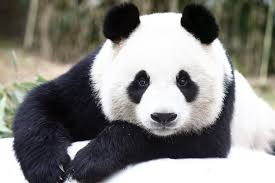

88.26% : giant panda
 0.18% : lesser panda
 0.08% : indri
 0.07% : brown bear
 0.07% : earthstar
 0.07% : digital watch
 0.06% : face powder
 0.06% : colobus
 0.06% : soccer ball
 0.06% : sea urchin


In [13]:
image_path = os.path.join('images/panda_recostado.jpg')
classify(image_path)

## Interpretación de los puntajes de Clasificación

La salida del modelo Inception es una función llamada Softmax.

Las salidas softmax son a veces llamadas Probabilidades porque están entre 0 y 1, y también suman 1 al igual que las probabilidades. Pero en realidad no son probabilidades en el sentido tradicional de la palabra, porque no provienen de experimentos repetidos.

Tal vez sea mejor llamar puntajes o rangos de clasificación a los valores de salida de una neural network porque indican cuán fuertemente cree la red que la imagen de entrada es de cada clase posible.

En el ejemplo con la imagen de un panda, el modelo Inception dio una puntuación muy alta de alrededor del 89% para la clase panda, y las puntuaciones para las restantes 999 clases posibles fueron todas inferiores al 1%. Esto significa que el modelo Inception estaba bastante seguro de que la imagen mostraba un panda y las puntuaciones restantes por debajo del 1% debían considerarse como ruido. Por ejemplo, la octava puntuación más alta fue de 0.05% para un reloj digital, pero esto es probablemente más debido a la naturaleza imprecisa de las neural networks en lugar de una indicación de que la imagen se veía ligeramente como un reloj digital.

A veces el modelo Inception está confundido acerca de qué clase pertenece una imagen, por lo que ninguna de las puntuaciones es realmente alta. Ejemplos de esto se muestran a continuación.

## Loro (imagen original)

El modelo Inception tiene alta confianza (puntuación alrededor del 97%) que esta imagen muestra una especie de loro llamada macaw.

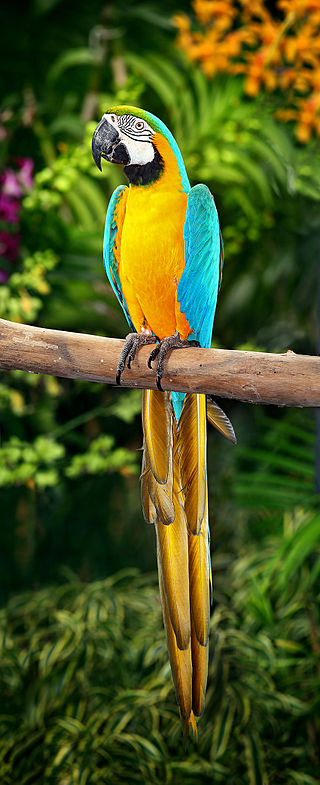

97.30% : macaw
 0.07% : African grey
 0.07% : toucan
 0.05% : jacamar
 0.04% : bee eater
 0.04% : lorikeet
 0.02% : sulphur-crested cockatoo
 0.02% : jay
 0.01% : kite
 0.01% : sandbar


In [14]:
classify(image_path="images/parrot.jpg")

## Loro (imagen redimensionada)

El modelo Inception funciona en imágenes de entrada de 299 x 299 píxeles de tamaño. La imagen anterior de un loro es en realidad 320 píxeles de ancho y 785 píxeles de alto, por lo que es redimensionada automáticamente por el modelo de inicio.

Ahora queremos ver la imagen después de haber sido redimensionada por el modelo Inception.

Primero tenemos una función auxiliar para obtener la imagen redimensionada desde el interior del modelo Inception.

In [15]:
def plot_resized_image(image_path):
    # Get the resized image from the Inception model.
    resized_image = model.get_resized_image(image_path=image_path)

    # Plot the image.
    plt.imshow(resized_image, interpolation='nearest')
    
    # Ensure that the plot is shown.
    plt.show()

Ahora ploteamos la imagen redimensionada del loro. Esta es la imagen que realmente se introduce en la neural network del modelo Inception. Podemos ver que ha sido contraida por lo que es cuadrada, y la resolución se ha reducido por lo que la imagen se ha vuelto más pixelada y granulada.

En este caso, la imagen todavía muestra claramente un loro, pero algunas imágenes pueden llegar a ser tan distorsionadas de este redimensionamiento ingenuo que es posible que desee cambiar el tamaño de las imágenes usted mismo antes de introducirlas en el modelo de inicio.

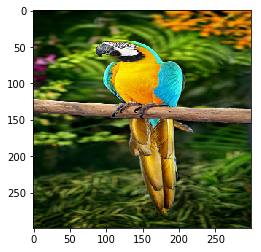

In [16]:
plot_resized_image(image_path="images/parrot.jpg")

## Loro (imagen recortada, arriba)

Esta imagen del loro se ha recortado manualmente a 299 x 299 píxeles y luego ingresa al modelo de Inception, que todavía tiene alta confianza (puntuación de alrededor del 97%) que muestra un loro (macaw).

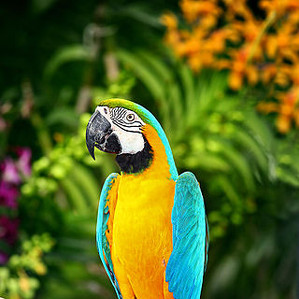

97.38% : macaw
 0.09% : African grey
 0.03% : sulphur-crested cockatoo
 0.02% : toucan
 0.02% : reflex camera
 0.01% : comic book
 0.01% : backpack
 0.01% : bib
 0.01% : vulture
 0.01% : lens cap


In [17]:
classify(image_path="images/parrot_cropped1.jpg")

## Loro (imagen recortada, medio)

Esta es otra edición de la imagen del loro, esta vez mostrando su cuerpo sin la cabeza o la cola. El modelo Inception sigue teniendo alta confianza (puntaje cerca de 94%) que demuestra un loro del macaw.

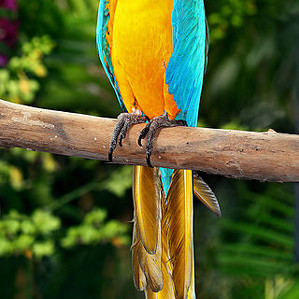

93.94% : macaw
 0.77% : toucan
 0.55% : African grey
 0.13% : jacamar
 0.12% : bee eater
 0.11% : sulphur-crested cockatoo
 0.10% : magpie
 0.09% : jay
 0.07% : lorikeet
 0.05% : hornbill


In [18]:
classify(image_path="images/parrot_cropped2.jpg")

## Loro (imagen recortada, abajo)

Esta imagen ha sido recortada y sólo muestra la cola del loro. Ahora el modelo Inception está bastante confundido y piensa que la imagen podría mostrar un jacamar (puntuación de alrededor del 26%) que es otro pájaro exótico, o tal vez la imagen muestra una tolva de hierba (puntuación de alrededor del 10%).

El modelo Inception también piensa que la imagen podría mostrar una pluma estilográfica (puntuación de alrededor del 2%). Pero esta es una puntuación muy baja y debe interpretarse como ruido poco fiable.

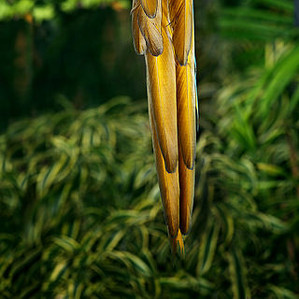

26.11% : jacamar
10.61% : grasshopper
 4.05% : chime
 2.24% : bulbul
 2.00% : fountain pen
 1.60% : leafhopper
 1.26% : cricket
 1.25% : kite
 1.13% : macaw
 0.80% : torch


In [19]:
classify(image_path="images/parrot_cropped3.jpg")

## Loro (imagen rellenada)

La mejor manera de ingresar imágenes al modelo Inception es rellenar la imagen para que sea cuadrada y luego cambiar el tamaño de la imagen a 299 x 299 píxeles, como este ejemplo del loro que se clasifica correctamente con una puntuación de aproximadamente el 97%.

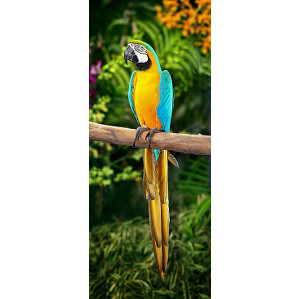

96.78% : macaw
 0.06% : toucan
 0.06% : African grey
 0.05% : bee eater
 0.04% : sulphur-crested cockatoo
 0.03% : king penguin
 0.03% : jacamar
 0.03% : lorikeet
 0.01% : kite
 0.01% : anemone fish


In [20]:
classify(image_path="images/parrot_padded.jpg")

## Elon Musk (299 x 299 pixels)

Esta imagen muestra al inventor y empresario Elon Musk. Pero el modelo Inception está muy confundido acerca de lo que muestra la imagen, prediciendo que tal vez muestra una sudadera (sweatshirt) (puntuación de alrededor del 17%) o un abaya (puntuación de alrededor del 16%). También piensa que la imagen puede mostrar una pelota de ping-pong (puntuación de alrededor del 3%) o una pelota de béisbol (puntuación de alrededor del 2%). Así que el modelo Inception está confundido y las puntuaciones de clasificación no son confiables.

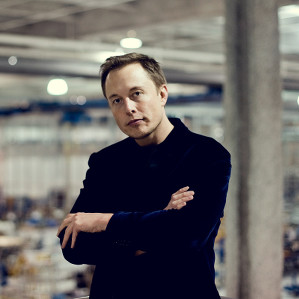

19.73% : sweatshirt
16.82% : abaya
 4.17% : suit
 3.46% : trench coat
 3.05% : ping-pong ball
 1.92% : cellular telephone
 1.86% : baseball
 1.77% : jersey
 1.54% : kimono
 1.43% : water bottle


In [21]:
classify(image_path="images/elon_musk.jpg")

## Elon Musk (100 x 100 pixels)

Si usamos una imagen de 100 x 100 píxeles de Elon Musk, entonces el modelo de Inception piensa que podría mostrar una sudadera (puntuación de alrededor del 22%) o una bota de vaquero (puntuación de alrededor del 14%). Así que ahora el modelo Inception tiene predicciones algo diferentes, pero todavía es poco confiable.

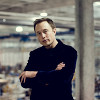

17.85% : sweatshirt
16.36% : cowboy boot
10.68% : balance beam
 8.87% : abaya
 5.36% : suit
 4.57% : Loafer
 2.94% : trench coat
 2.65% : maillot
 1.87% : jersey
 1.42% : unicycle


In [22]:
classify(image_path="images/elon_musk_100x100.jpg")

El modelo Inception automáticamente actualiza esta imagen de 100 x 100 a 299 x 299 píxeles, como se muestra. Observamos cómo se pixelea, aunque un humano puede ver fácilmente que ésta es una imagen de un hombre con los brazos cruzados.

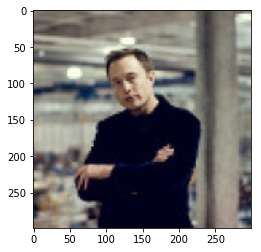

In [23]:
plot_resized_image(image_path="images/elon_musk_100x100.jpg")

## Willy Wonka (Gene Wilder)

Esta imagen muestra al actor Gene Wilder representando a Willy Wonka en la versión de 1971 de la película. El modelo Inception está muy seguro de que la imagen muestra una corbata michi o bow-tie (puntuación de alrededor del 98%), lo cual es cierto, pero un humano probablemente diría que esta imagen muestra a una persona.

La razón podría ser que el modelo Inception fue entrenado en imágenes de personas con corbata michi que fueron clasificados como una corbata en vez de una persona. Así que tal vez el problema es que el nombre de la clase debe ser "persona con corbata" en lugar de simplemente "bow-tie".

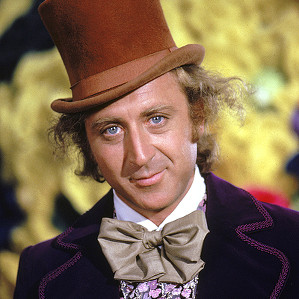

97.22% : bow tie
 0.92% : cowboy hat
 0.21% : sombrero
 0.09% : suit
 0.06% : bolo tie
 0.05% : Windsor tie
 0.04% : cornet
 0.03% : flute
 0.02% : banjo
 0.02% : revolver


In [24]:
classify(image_path="images/willy_wonka_old.jpg")

## Willy Wonka (Johnny Depp)

Esta imagen muestra al actor Johnny Depp interpretando a Willy Wonka en la versión 2005 de la película. El modelo Inception piensa que esta imagen muestra "gafas de sol" (puntuación de alrededor del 34%) o "gafa de sol" (puntuación de alrededor del 18%). En realidad, el nombre completo de la primera clase es "gafas de sol, gafas oscuras, sombras". Por alguna razón, el modelo Inception ha sido entrenado para reconocer dos clases muy similares de gafas de sol. Una vez más, es correcto que la imagen muestra gafas de sol, pero un humano probablemente habría dicho que esta imagen muestra a una persona.

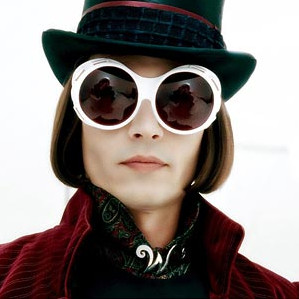

31.48% : sunglasses
18.77% : sunglass
 1.55% : velvet
 1.02% : wig
 0.77% : cowboy hat
 0.69% : seat belt
 0.67% : sombrero
 0.62% : jean
 0.46% : poncho
 0.43% : jersey


In [25]:
classify(image_path="images/willy_wonka_new.jpg")

## Cierre de Sesión de TensorFlow

Como estamos usando TensorFlow, cerramos la sesión para liberar sus recursos.

In [26]:
# model.close()

## Conclusión

Toma muchas semanas entrenar el modelo Inception, pero para este caso sólo descargamos el modelo terminado desde Internet y los usamos en un PC normal para clasificar imágenes.
Desafortunadamente, el modelo Inception parece tener problemas para reconocer personas. Esto puede ser a causa del training-set que fue usado.